In [6]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import efficientnet
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import cv2

In [7]:
train_dir = '../../data/dogs-vs-cats/cat_dog_full/train'
valid_dir = '../../data/dogs-vs-cats/cat_dog_full/validation'

IMAGE_SIZE = 256
BATCH_SIZE = 8
LEARNING_RATE = 5e-5

def generate_preprocessing(img):
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    return img

train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=40,
#                                    width_shift_range=0.1,
#                                    height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   preprocessing_function=generate_preprocessing,
                                   fill_mode='nearest')      

valid_datagen = ImageDataGenerator(rescale=1/255.0,
                                   preprocessing_function=generate_preprocessing)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=['cats', 'dogs'],                                                    
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    classes=['cats', 'dogs'],                                                    
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary',
                                                    shuffle=False)

Found 14000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


In [8]:
IMAGE_SIZE = 256
BATCH_SIZE = 8

In [9]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE ,3), include_top=False, weights='imagenet')
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(50, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [10]:
# Early Stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=5,
                   verbose=1)

# Checkpoint
model_checkpoint = './{epoch:06d}-{val_acc:0.6f}-{acc:0.6f}.ckpt'

checkpointer = ModelCheckpoint(
    filepath=model_checkpoint,
    verbose=1,
    patience=10,
    mode='min',
    monitor='val_loss'
)

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min', verbose=1)

In [11]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['acc'])

In [12]:
# for layer in model.layers[-10:-4]:
#     layer.trainable = False
    
for layer in model.layers[:-4]:
    layer.trainable = False

for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001E38476C910> False
<keras.layers.convolutional.Conv2D object at 0x000001E3F1D8CFD0> False
<keras.layers.convolutional.Conv2D object at 0x000001E384747BE0> False
<keras.layers.pooling.MaxPooling2D object at 0x000001E3F1D8C820> False
<keras.layers.convolutional.Conv2D object at 0x000001E384747940> False
<keras.layers.convolutional.Conv2D object at 0x000001E39B5963A0> False
<keras.layers.pooling.MaxPooling2D object at 0x000001E384A27340> False
<keras.layers.convolutional.Conv2D object at 0x000001E39B59CBB0> False
<keras.layers.convolutional.Conv2D object at 0x000001E39B596BE0> False
<keras.layers.convolutional.Conv2D object at 0x000001E39B5A2E50> False
<keras.layers.pooling.MaxPooling2D object at 0x000001E39B59C730> False
<keras.layers.convolutional.Conv2D object at 0x000001E39B5A86D0> False
<keras.layers.convolutional.Conv2D object at 0x000001E39B5B17F0> False
<keras.layers.convolutional.Conv2D object at 0x000001E39B5ACB80> False
<ker

In [13]:
history = model.fit(train_generator,                    
                    epochs=100,
                    validation_data=valid_generator,                    
                    callbacks=[es, checkpointer, rlp],
                    verbose=1)

Epoch 1/100
1750/1750 [==============================] - ETA: 0s - loss: 0.6041 - acc: 0.6472
Epoch 1: saving model to .\000001-0.856833-0.647214.ckpt
INFO:tensorflow:Assets written to: .\000001-0.856833-0.647214.ckpt\assets
1750/1750 [==============================] - 298s 168ms/step - loss: 0.6041 - acc: 0.6472 - val_loss: 0.3496 - val_acc: 0.8568 - lr: 5.0000e-05
Epoch 2/100
1750/1750 [==============================] - ETA: 0s - loss: 0.2963 - acc: 0.8729
Epoch 2: saving model to .\000002-0.927000-0.872857.ckpt
INFO:tensorflow:Assets written to: .\000002-0.927000-0.872857.ckpt\assets
1750/1750 [==============================] - 288s 165ms/step - loss: 0.2963 - acc: 0.8729 - val_loss: 0.1666 - val_acc: 0.9270 - lr: 5.0000e-05
Epoch 3/100
1750/1750 [==============================] - ETA: 0s - loss: 0.2067 - acc: 0.9164
Epoch 3: saving model to .\000003-0.945000-0.916429.ckpt
INFO:tensorflow:Assets written to: .\000003-0.945000-0.916429.ckpt\assets
1750/1750 [==========================

Epoch 23/100
1750/1750 [==============================] - ETA: 0s - loss: 0.0231 - acc: 0.9912
Epoch 23: saving model to .\000023-0.983000-0.991214.ckpt
INFO:tensorflow:Assets written to: .\000023-0.983000-0.991214.ckpt\assets
1750/1750 [==============================] - 294s 168ms/step - loss: 0.0231 - acc: 0.9912 - val_loss: 0.0561 - val_acc: 0.9830 - lr: 1.0000e-05
Epoch 24/100
1750/1750 [==============================] - ETA: 0s - loss: 0.0201 - acc: 0.9918
Epoch 24: saving model to .\000024-0.984333-0.991786.ckpt
INFO:tensorflow:Assets written to: .\000024-0.984333-0.991786.ckpt\assets
1750/1750 [==============================] - 292s 167ms/step - loss: 0.0201 - acc: 0.9918 - val_loss: 0.0546 - val_acc: 0.9843 - lr: 1.0000e-05
Epoch 25/100
1750/1750 [==============================] - ETA: 0s - loss: 0.0204 - acc: 0.9937
Epoch 25: saving model to .\000025-0.981833-0.993714.ckpt
INFO:tensorflow:Assets written to: .\000025-0.981833-0.993714.ckpt\assets

Epoch 25: ReduceLROnPlateau re

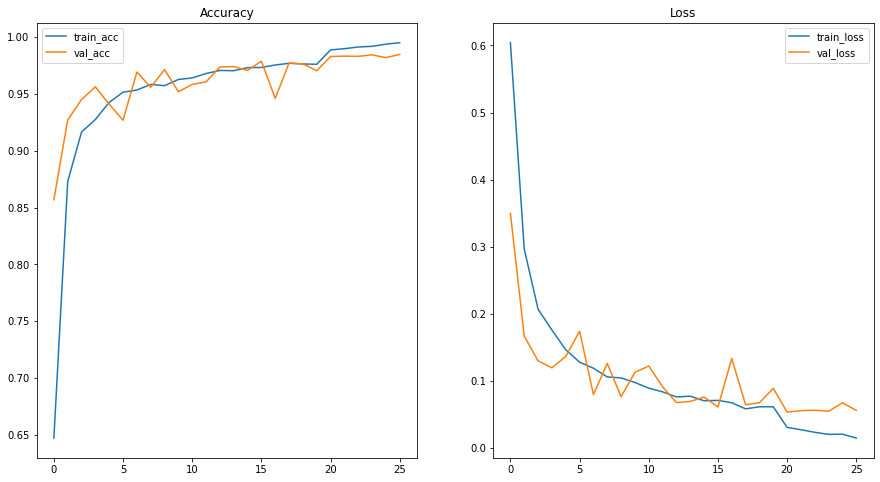

In [14]:
figure, axs = plt.subplots(figsize=(15, 8), nrows=1, ncols=2)

axs[0].plot(history.history['acc'], label='train_acc')
axs[0].plot(history.history['val_acc'], label='val_acc')
axs[0].set_title('Accuracy')

axs[1].plot(history.history['loss'], label='train_loss')
axs[1].plot(history.history['val_loss'], label='val_loss')
axs[1].set_title('Loss')

axs[0].legend()
axs[1].legend()
plt.show()